# Team Information & Contents 

|Team-number :| 8|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Altuğ Demirşah| demira02@ads.uni-passau.de|109776|
|Elif Günay| guenay01@ads.uni-passau.de|109806|
|Evren Can| can05@ads.uni-passau.de|109484|

**

----------------------------------------------------------------------

**


This report is provided for the sub-assignment of the Deep Learning and Text Analysis in Finance course at the University of Passau on WiSe 21/22.

**

**Aim**: This report contains our own preprocessing and modelling approaches for a [competition](https://https://www.kaggle.com/c/g-research-crypto-forecasting) based on Kaggle and this competition aims to predict some of the most popular cryptocurrencies' future changes.

**In summary**, we prefered working on BTC and ETH cryptocurrencies, built two different models for the purpose of predicting their *Target* and those models are built-on LSTM and GRU, fine-tuned hyperparameters to get better performance, evaluated the outputs and made some final comments.

**

Contents:

1.   **Import needed libraries**
2.   **Data Preprocessing**
    
    2.1. Reading datasets

    2.2. Dealing with missing data
    
    2.3. Picking two coins to work with

    2.4. Plot data

    2.5. Split & Scale data

    2.6. Observation & Next Price

    2.7. Oversee preprocessed data

3. **Modelling**

    3.1. Modelling 1
    
      - 3.1.1. train

      - 3.1.2. performence

      - 3.1.3. predict

  3.2. Modelling 2
    
      - 3.2.1. train

      - 3.2.2. performence

      - 3.2.3. predict

4. **Evaluation**

    4.1. Evaluation on model 1

    4.2. Evaluation on model 2

5. Comments

    5.1. regarding to model 1

    5.2. regarding to model 2

    5.3. regarding to hyper parameters

    5.4. regarding to technical analysis

    5.5. final comments


In order to run this code file, these should be considered:
*   This code file was created on Google Colab and data was uploaded from Google Drive.
*   Since we run this code file on the basic Colab version, limited memory and computational sources are provided by the platform. Running this code file on a different device might require/take a long time depending on the sources that the device has.



# Import needed libraries

In [ ]:
"""
Needed libraries:

  For data proprocessing:

    pandas: we use pandas library to manipulate data and analyse inside of it. In our case, manipulating numerical tables and time series.
    numpy:  we use numpy since it offers a large collection of high-level mathematical functions to operate on the arrays.
    matplotlib: matplotlib is a plotting library. In our case, we plot change of a cryptocurrency by time
    datetime: datetime module supplies classes for manipulating dates and times. In our case, converting timestamps into the UTC datetime corresponding to the POSIX timestamp
    sklearn:  to change raw feature vectors into a representation that is more suitable for the downstream estimators. In our case, scaling data with StandardScaler or MinMaxScaler

  For modelling:

    tensorflow:  used to design, build, and train deep learning models. 
      ->  layers: this is the class from which all layers inherit such as LSTM, GRU, Dense and so on

"""
# data proprocessing
import pandas as pd                                                 
import numpy as np                                                  
import matplotlib.pyplot as plt                                    
from datetime import datetime as dt                                 
from sklearn.preprocessing import StandardScaler, MinMaxScaler     

# modelling
import tensorflow as tf                                             
from tensorflow import keras
from keras import layers

## Connecting to Google Drive

In [ ]:
# to download data, first we need to connect to google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Data preprocessing

## Reading datasets

In [ ]:
%%time
'''
    timestamp - a timestamp for the minute covered by the row.
    Asset_ID - an ID code for the cryptoasset.
    Count - the number of trades that took place this minute. 
    Open - the USD price at the beginning of the minute. 
    High - the highest USD price during the minute. 
    Low - the lowest USD price during the minute. 
    Close - the USD price at the end of the minute. 
    Volume - the number of cryptoasset units traded during the minute. 
    VWAP - the volume weighted average price for the minute. 
    Target - is derived from log returns over 15 minutes

'''
train_dtypes={
    'timestamp': np.int64,
    'Asset_ID': np.int8,
    'Count': np.int64,
    'Open': np.float64,
    'High': np.float64,
    'Low': np.float64,
    'Close': np.float64,
    'Volume': np.float64,
    'VWAP': np.float64,
    'Target': np.float64,
}

#############################################################################################################################################

"""
    Asset_ID - an ID code for the cryptoasset
    Weight - each cryptoasset receives in the metric
    Asset_Name - the real name and of the cryptoasset

"""
asset_dtypes= {
    'Asset_ID': np.int8,
    'Weight': np.float64,
    'Asset_Name': np.object
}

#############################################################################################################################################

# load train data
train_PATH = '/gdrive/MyDrive/DLTA/Data/train.csv'
df = pd.read_csv(train_PATH, sep=',', dtype=train_dtypes, usecols=list(train_dtypes.keys()))

# convert timestamps into Time column that contains the UTC datetime corresponding to the POSIX timestamp
df['Time'] = [dt.utcfromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S') for d in df.timestamp]

# load asset details
asset_PATH = '/gdrive/MyDrive/DLTA/Data/asset_details.csv'
asset_details = pd.read_csv(asset_PATH, sep=',', dtype=asset_dtypes, usecols=list(asset_dtypes.keys()))

# merge df and asset details to get all columns in a table
df = pd.merge(df, asset_details,
                on ="Asset_ID",
                how = 'left')

# print a concise summary of the dataframe
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24236806 entries, 0 to 24236805
Data columns (total 13 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   timestamp   24236806 non-null  int64  
 1   Asset_ID    24236806 non-null  int8   
 2   Count       24236806 non-null  int64  
 3   Open        24236806 non-null  float64
 4   High        24236806 non-null  float64
 5   Low         24236806 non-null  float64
 6   Close       24236806 non-null  float64
 7   Volume      24236806 non-null  float64
 8   VWAP        24236797 non-null  float64
 9   Target      23486468 non-null  float64
 10  Time        24236806 non-null  object 
 11  Weight      24236806 non-null  float64
 12  Asset_Name  24236806 non-null  object 
dtypes: float64(8), int64(2), int8(1), object(2)
memory usage: 2.4+ GB
CPU times: user 1min 50s, sys: 8.35 s, total: 1min 58s
Wall time: 2min 13s


In [ ]:
# tabular data
df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Time,Weight,Asset_Name
0,1514764860,2,40,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218,2018-01-01 00:01:00,2.397895,Bitcoin Cash
1,1514764860,0,5,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399,2018-01-01 00:01:00,4.304065,Binance Coin
2,1514764860,1,229,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643,2018-01-01 00:01:00,6.779922,Bitcoin
3,1514764860,5,32,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922,2018-01-01 00:01:00,1.386294,EOS.IO
4,1514764860,7,5,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264,2018-01-01 00:01:00,2.079442,Ethereum Classic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN,2021-09-21 00:00:00,2.397895,Litecoin
24236802,1632182400,10,34,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN,2021-09-21 00:00:00,1.098612,Maker
24236803,1632182400,13,380,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN,2021-09-21 00:00:00,1.791759,TRON
24236804,1632182400,12,177,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN,2021-09-21 00:00:00,2.079442,Stellar


As it is seen, it is a big dataframe with approximately 24 million rows and 13 columns, also, including price changes of 14 cryptocurrencies per minute between 1st of January 2018 and 21st of September 2021.

## Dealing with missing data

Missing data is a common challenge that leads to a loss of information and hence reduced statistical power, a more insidious consequence is that this lack of data may introduce selection bias, which could potentially invalidate the entire study, especially during working with timeseries. So before we pick two different cryptocurrencies, with the intent of avoiding missing data, we first investigate each cryptocurrency in detail.

In [ ]:
%%time
def missing_data(df : pd.DataFrame) -> None:
  
  """
  Observing missing datas and details of each coin

  Arg:
    df (pf.DataFrame): a table that will be explored

  Returns:
    None
  
  """
  
  # there are 14 different cryptocurrencies in the dataset
  for i in range(14):
    coin_table = df[df['Asset_ID'] == i]
    coin = df[df['Asset_ID'] == i]['Asset_Name']
    coin.reset_index(drop=True, inplace = True)
    missing_values = df[df['Asset_Name'] == coin[0]].isna().sum()
    print(f'Asset_ID: {i}, \t Asset_Name: {coin[0]} \n\nmissing values for each column: \n\n{missing_values}\n\n')

    # info
    print('Asset info:\n')
    print(pd.DataFrame(coin_table).info(null_counts=True))
    print('\n\n', '*'*120, '\n', '*'*120, '\n\n')

  
  # del temporary variables to avoid memory problem
  del coin, coin_table, missing_values
  
  return None


missing_data(df)

Asset_ID: 0, 	 Asset_Name: Binance Coin 

missing values for each column: 

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              0
Target        13415
Time              0
Weight            0
Asset_Name        0
dtype: int64


Asset info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942619 entries, 1 to 24236794
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   timestamp   1942619 non-null  int64  
 1   Asset_ID    1942619 non-null  int8   
 2   Count       1942619 non-null  int64  
 3   Open        1942619 non-null  float64
 4   High        1942619 non-null  float64
 5   Low         1942619 non-null  float64
 6   Close       1942619 non-null  float64
 7   Volume      1942619 non-null  float64
 8   VWAP        1942619 non-null  float64
 9   Target      1929204 non-null  float64
 10  T

- Except for the *Target* column, non of the other columns of each cryptocurrency contains any missing value. Since it is expected to use *Target* data to build a model, it is important to choose the cryptocurrencies that have the least missing value in the *Target* column. In this case, BTC and ETH have the lowest missing values. 

- If we look at the concise summary of each cryptocurrency, BTC and ETH have the highest amount of row numbers (almost equal to each other, approximately 2 million rows) compare to the other assets. We think that since both of the assets have fewer missing data points compared to the other assets in the specified timezone, feeding them through a model might perform better than feeding the other assets.

## Picking two coins to work with

If we take the analysis above into consideration, it can be seen that BTC and ETH are the most promising coins in order to feed through a model. Also, according to [Coinmarketcap](https://https://coinmarketcap.com/), they have the biggest market cap in the cryptocurrency ecosystem and we found that predicting their future changes would be quite exciting. For these reasons, we prefer picking **BTC** and **ETH** to build two models that predict their future prices.

In [ ]:
%%time
def create_coin_df(df : pd.DataFrame, asset_id : int) -> pd.DataFrame:
  """
  This function allows us creating a new coin dataframe in order to work with the coin later to predict its future price
  
  Arg:
    df (pf.DataFrame): a dataframe that will be worked on
    asset_id: coin's asset_id that will be picked

  Return:
    pd.DataFrame
  """
  
  # we drop some columns that are not needed anymore
  coin = df[df['Asset_ID'] == asset_id].drop(['Asset_ID', 'timestamp', 'Weight', 'Asset_Name'], axis=1)

  # we prefer dropping the rows where Target has NaN data, instead of filling them, in order to avoid information leakage
  coin = coin[coin['Target'].notna()]

  # reset index to have clear view
  coin = coin.reset_index().drop(['index'], axis=1)
  
  # print chosen asset's dataframe
  with pd.option_context('display.max_columns', None):  
    print(coin)
  
  return coin


print('Bitcoin: ')
btc = create_coin_df(df, 1)     # btc index_id -> 1

print('\n')
print('*'*150)
print('\n')

print('Ethereum: ')
eth = create_coin_df(df, 6)     # eth index_id -> 6


# we don't need the entire dataset anymore so deleting df to avoid memory problem
del df

Bitcoin: 
         Count         Open      High       Low         Close      Volume  \
0          229  13835.19400  14013.80  13666.11  13850.176000   31.550062   
1          235  13835.03600  14052.30  13680.00  13828.102000   31.046432   
2          528  13823.90000  14000.40  13601.00  13801.314000   55.061820   
3          435  13802.51200  13999.00  13576.28  13768.040000   38.780529   
4          742  13766.00000  13955.90  13554.44  13724.914000  108.501637   
...        ...          ...       ...       ...           ...         ...   
1955973   2643  42632.46500  42736.90  42607.50  42703.636250  100.797218   
1955974   2281  42718.81500  42819.38  42690.84  42781.970571   76.339988   
1955975   2642  42772.92125  42827.10  42690.75  42755.592500  117.429123   
1955976   2134  42762.29000  42811.30  42694.37  42717.234286   78.049458   
1955977   2165  42703.80250  42752.00  42636.76  42657.202500   86.518794   

                 VWAP    Target                 Time  
0        1

## Plotting prices and candlesticks

Let's plot coins price change by the given time in order to get familiar with how the price of each evolved

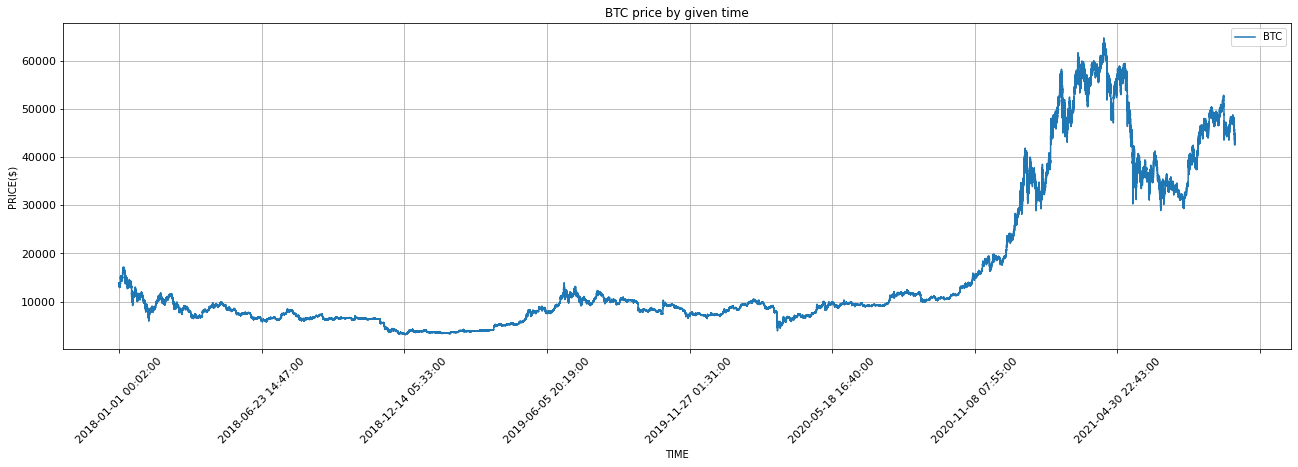

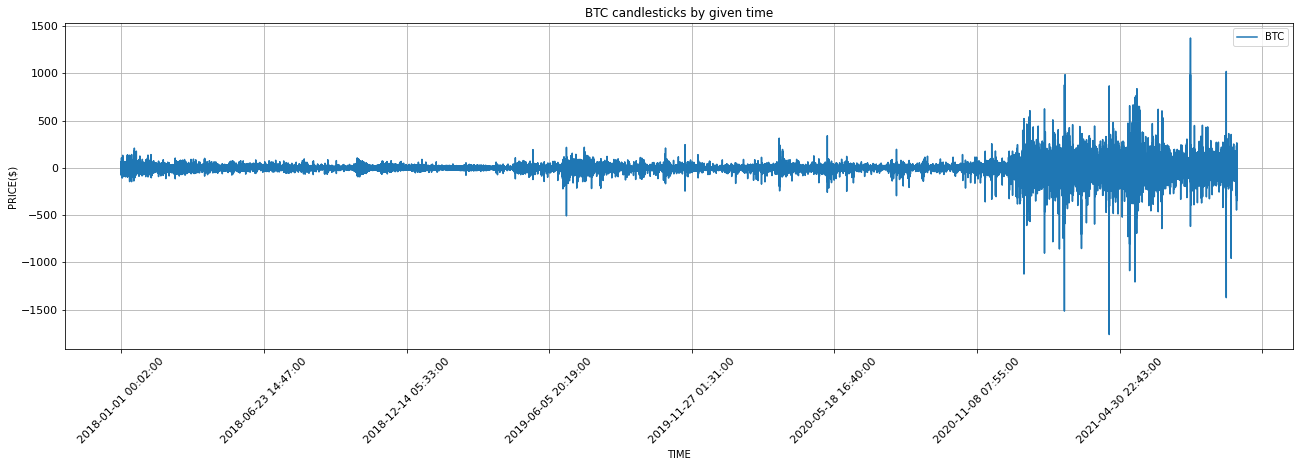

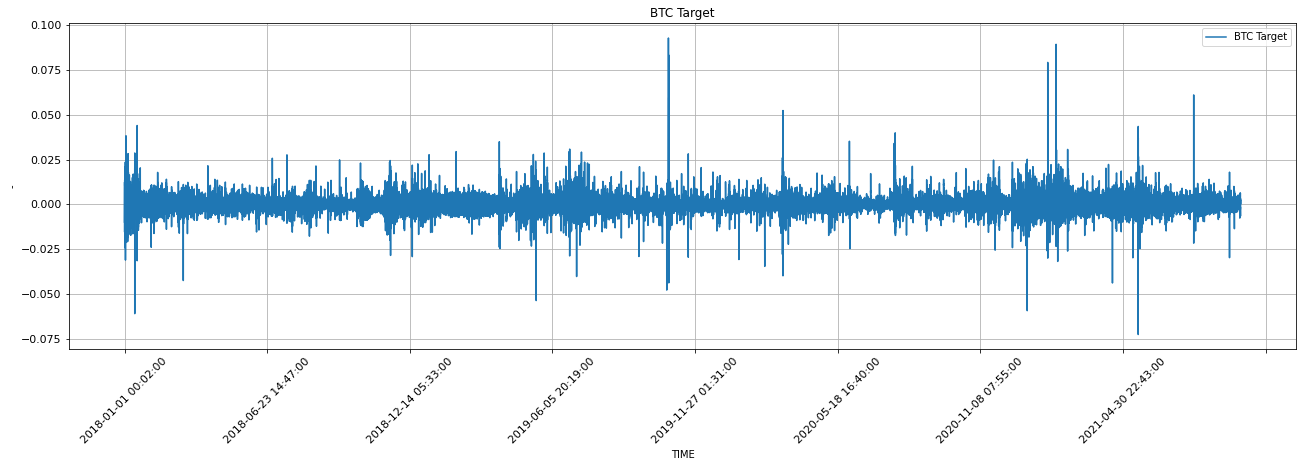






XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX






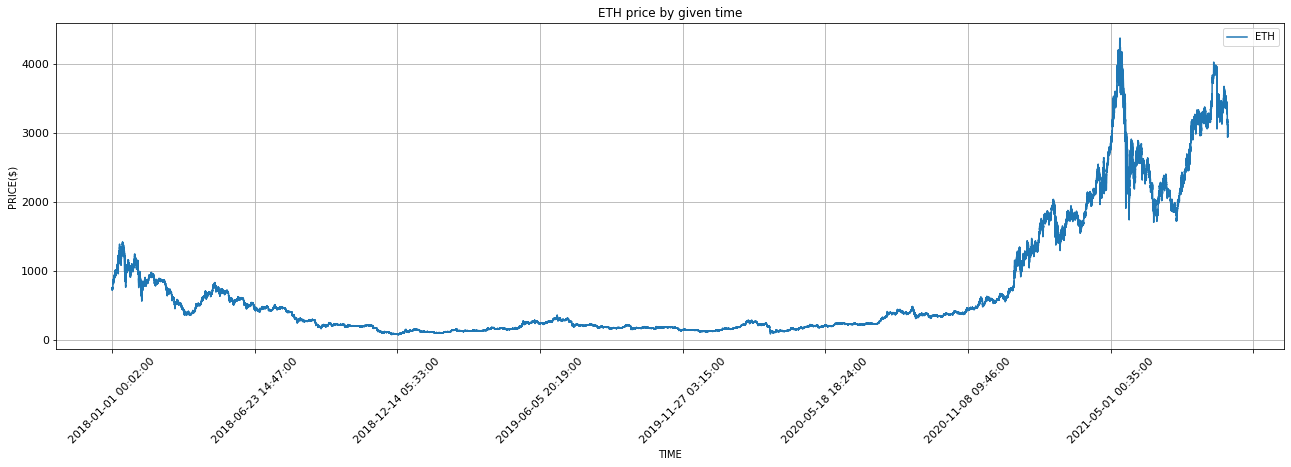

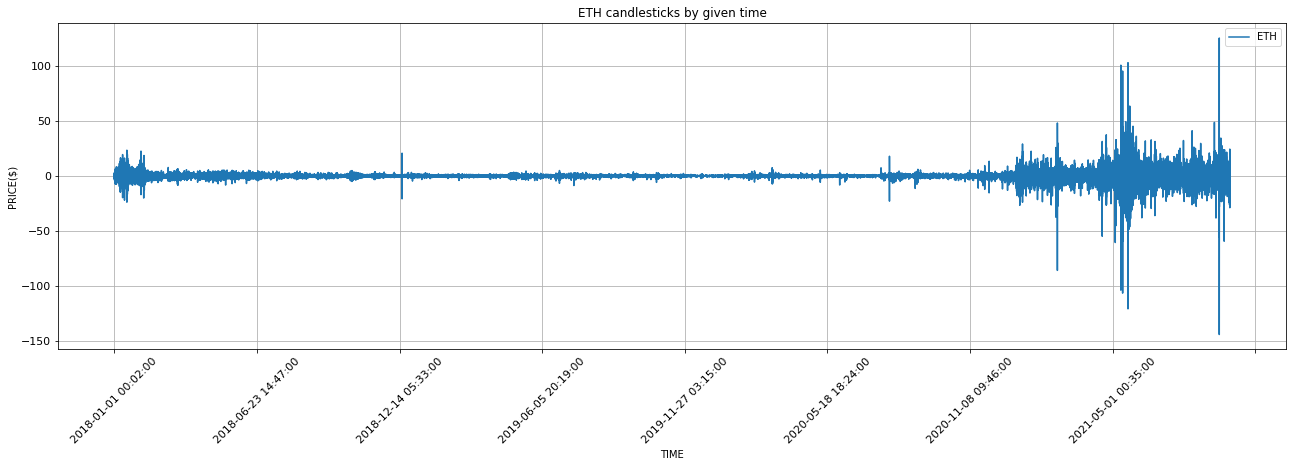

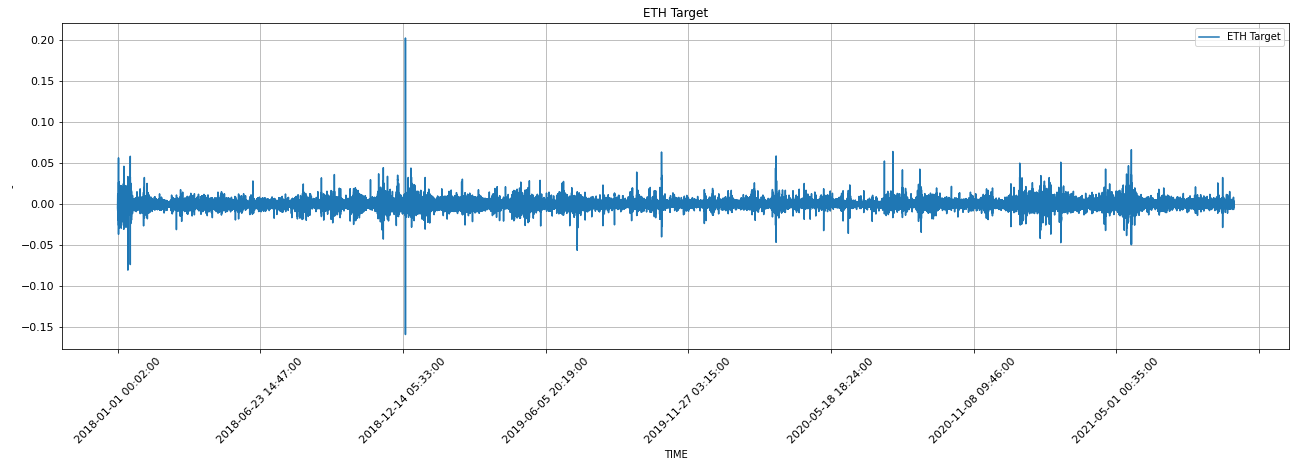



CPU times: user 6.24 s, sys: 454 ms, total: 6.69 s
Wall time: 6.73 s


In [ ]:
%%time
def coin_visualization(df : pd.DataFrame, coin_name : str) -> None:
  """
  Coin price change exploration and visualization by given time

  Arg:
    df (pf.DataFrame): a coin table, its price will be explored and visualized
    coin_name: name of the coin that will be visualized
  
  Returns:
    None
  """

  coin = pd.DataFrame(df['VWAP'], columns=['VWAP'])
  coin['Target'] = df['Target']
  coin.index = df['Time']
  coin.index.name = None
  coin['Candlesticks'] = coin['VWAP'] - coin['VWAP'].shift(1)
  coin = coin[1:]

  print('\n')

  price_title = f'{coin_name} price by given time'
  coin['VWAP'].plot(title=price_title, fontsize=11, figsize=(22,6), rot=45, grid=True)
  plt.ylabel('PRICE($)')
  plt.xlabel('TIME')
  plt.legend([f'{coin_name}'], loc='upper right')
  plt.show()

  print('\n')
  
  # Candlesticks show that emotion by visually representing the size of price moves per min in our case.
  candle_title = f'{coin_name} candlesticks by given time'
  coin['Candlesticks'].plot(title=candle_title, fontsize=11, figsize=(22,6), rot=45, grid=True)
  plt.ylabel('PRICE($)')
  plt.xlabel('TIME')
  plt.legend([f'{coin_name}'], loc='upper right')
  plt.show()

  print('\n')

  price_title = f'{coin_name} Target'
  coin['Target'].plot(title=price_title, fontsize=11, figsize=(22,6), rot=45, grid=True)
  plt.ylabel('-')
  plt.xlabel('TIME')
  plt.legend([f'{coin_name} Target'], loc='upper right')
  plt.show()

  print('\n')

  # del temporary variables to avoid memory problem
  del coin, price_title, candle_title

  return None


coin_visualization(btc, 'BTC')

print('\n\n')
print('X'*150)
print('\n')

coin_visualization(eth, 'ETH')

The graphs above give interesting and enlightening pieces of knowledge about each of the coin prices change by the given timeline. 

From the beginning of 1st of January 2018 till the end of 2020, the market cap of each coin seems slightly constant between the same values, except the first half of 2018. During the end of 2020, both of the coin prices made a rapid jump, which caused gaining more value and becoming more volatile for each coin. 

Also, we can say that, since it is required to take the timeline later from beginning of June 2021 as a test set, dramatic price changes during the mentioned time make training a model that learns from the given data more challenging and bring some biases.

## Splitting & scaling data

Now, we split data into **train**, **validation** and **test** sets in order to feed through a model. In this sense, having a validation set helps us for fine-tuning the parameters of the model and avoiding over-fitting problems.


Related to scaling, we will be building type of RNN models that basically contains Gradient Descent Based algorithms. On this purpose, scaling benefits optimization by:

- It makes the training faster
- It prevents the optimization from getting stuck in local optima
- It gives a better error surface shape



We preferred applying standardization on our data depending on the information we got from this page: https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

Basically, in regression analysis, it is often crucial to standardize independent variables or we may risk obtaining misleading results.

$$
Z = \frac{x - \mu}{\sigma}
$$

*Z*	=	standard score

*x*	=	observed value

$\mu$	=	mean of the sample

$\sigma$	=	standard deviation of the sample


Generally speaking, the best practice is to use only the training set to figure out how to scale/normalize, then blindly apply the same transform to the valid and the test set in order to:
- keep them identical 
- avoid leading to random skew in the data

In [ ]:
def split_scale_data(df : pd.DataFrame, valid_threshold : str, test_threshold : str, coin_name : str, scaler_method : StandardScaler()) -> pd.DataFrame:
  
  """
  Split data into train, validation, test sets and scale them

  Arg:
    df (pf.DataFrame): a coin table, that will be splited into train, valid and test sets
    valid_threshold: a time point, valid dataset will be created from that point until test threshold point
    test_threshold: a time point, test dataset will be created from that point
    scaler_method: a scaler method, sklearn.preprocessing.StandardScaler is set as default
    coin_name: name of the coin that will be printed

  Return:
    returns scaled train, scaled validation, scaled test sets and coin scaler
  """
  
  valid_threshold_index = df[df['Time'] == valid_threshold].index.values[0]
  print(f'valid_threshold_index: {valid_threshold_index}')
  test_threshold_index = df[df['Time'] == test_threshold].index.values[0]
  print(f'test_threshold_index: {test_threshold_index}')
  
  # We keep VWAP column since it basically gives weighted average of Open, High, Low and Close columns
  # That is why we drop Open, High, Low and Close columns in order to avoid having too much information and messing up

  # train set
  coin_train = pd.DataFrame(df['Count'][:valid_threshold_index], columns=['Count'])
  coin_train['VWAP'] = df['VWAP'][:valid_threshold_index]
  coin_train['Time'] = df['Time'][:valid_threshold_index]
  coin_train['Target'] = df['Target'][:valid_threshold_index]                        
  coin_train['Volume'] = df['Volume'][:valid_threshold_index]                        
  coin_train['Gap'] = coin_train['VWAP'] - coin_train['VWAP'].shift(1)               # Gap: represents price changes between per min
  coin_train = coin_train[1:] 

  # valid set
  coin_valid = pd.DataFrame(df['Count'][valid_threshold_index:test_threshold_index], columns=['Count'])
  coin_valid['VWAP'] = df['VWAP'][valid_threshold_index:test_threshold_index]
  coin_valid['Time'] = df['Time'][valid_threshold_index:test_threshold_index]
  coin_valid['Target'] = df['Target'][valid_threshold_index:test_threshold_index]
  coin_valid['Volume'] = df['Volume'][valid_threshold_index:test_threshold_index]
  coin_valid['Gap'] = coin_valid['VWAP'] - coin_valid['VWAP'].shift(1)               # Gap: represents price changes between per min
  coin_valid = coin_valid[1:] 

  # test test
  coin_test = pd.DataFrame(df['Count'][test_threshold_index:], columns=['Count'])
  coin_test['VWAP'] = df['VWAP'][test_threshold_index:]
  coin_test['Time'] = df['Time'][test_threshold_index:]
  coin_test['Target'] = df['Target'][test_threshold_index:]
  coin_test['Volume'] = df['Volume'][test_threshold_index:]
  coin_test['Gap'] = coin_test['VWAP'] - coin_test['VWAP'].shift(1)                   # Gap: represents price changes between per min
  coin_test = coin_test[1:]


  # scaling
  scaler = scaler_method

  coin_train['Scaled_Target'] = scaler.fit_transform(coin_train['Target'].values.reshape(-1, 1))  # scaling based on train set
  coin_valid['Scaled_Target'] = scaler.transform(coin_valid['Target'].values.reshape(-1, 1))      # valid set must use identical scaling to the training set.
  coin_test['Scaled_Target'] = scaler.transform(coin_test['Target'].values.reshape(-1, 1))        # test set must use identical scaling to the training set.

  
  # print data sets

  print(f'\n\n{coin_name} train: \n')
  with pd.option_context('display.max_columns', None):  
    print(coin_train)

  print(f'\n\n{coin_name} valid: \n')
  with pd.option_context('display.max_columns', None): 
    print(coin_valid)

  print(f'\n\n{coin_name} test: \n')
  with pd.option_context('display.max_columns', None): 
    print(coin_test)


  return coin_train, coin_valid, coin_test, scaler


# Since prices through the timeline are not constant and there is no sufficient time period to set validation set as we observed
# we preferred creating a validation set with the size which is equivalent to the test set size based on our intuitions
# so this way each of them indicates around 13% of all data
valid_threshold = '2021-02-11 00:01:00'

# test set is required to pick from 2021-05-31 23:59:00 due to the task
test_threshold = '2021-05-31 23:59:00'

btc_train, btc_valid, btc_test, btc_scaler = split_scale_data(btc, valid_threshold, test_threshold, 'BTC', scaler_method=StandardScaler())
print('\n', '*'*100, '\n', '*'*100)
eth_train, eth_valid, eth_test, eth_scaler = split_scale_data(eth, valid_threshold, test_threshold, 'ETH', scaler_method=StandardScaler())

# we don't need the entire BTC and ETH dataset anymore so deleting them to avoid memory problem
del btc, eth

valid_threshold_index: 1636321
test_threshold_index: 1794716


BTC train: 

         Count          VWAP                 Time    Target      Volume  \
1          235  13840.362591  2018-01-01 00:02:00 -0.015037   31.046432   
2          528  13806.068014  2018-01-01 00:03:00 -0.010309   55.061820   
3          435  13783.598101  2018-01-01 00:04:00 -0.008999   38.780529   
4          742  13735.586842  2018-01-01 00:05:00 -0.008079  108.501637   
5          554  13706.952030  2018-01-01 00:06:00 -0.004422   70.805776   
...        ...           ...                  ...       ...         ...   
1636316   1864  44935.449789  2021-02-10 23:56:00 -0.007227   39.538163   
1636317   1826  44913.353225  2021-02-10 23:57:00 -0.008847   48.526747   
1636318   2467  44912.705558  2021-02-10 23:58:00 -0.007998   92.074357   
1636319   2466  44848.417638  2021-02-10 23:59:00 -0.007590   86.665774   
1636320   2956  44862.019363  2021-02-11 00:00:00 -0.010984  111.507314   

               Gap  Sca

## Observation & Next Price

Instead of using K-Fold cross-validation, we should be aware of the fact that a time series is not randomly distributed data — It is inherently ordered by chronological order. Therefore, using K-Fold cross validation is not helpful in our case.

In the case of time series data, we use techniques like forward-chaining 
 where the model will learn on past data then look at forward-facing data.

e.g.
    
    Dataset: [1 2 3 4 5 6 7 8 ...]
    1st Observation vector: [1 2 3 4 5]   
        next price 6
    2nd  Observation vector: [2 3 4 5 6]
        next price 7
      ...
      ..
      .

We prefer calling the training vector above as **observation** and the test set above as **next price** since it is more catchy.


We also set the dimension of the observation vector as **60** to make the training time of the model convenient and we thought it might be beneficial since it fits into one hour, and one hour in the trading market might present much good info.

In [ ]:
%%time
def observation_and_next_price(df : pd.DataFrame, dimension : int, df_name : str) -> np.array:
  """
  Generating observation vector with the specified dimension by the user in order to predict next price

  Arg:
    df: dataframe that includes the data that we will use to generate observation vectors
    dimension: lenght of observation vector
    df_name: coin name that will be printed

  Return:

  """

  # picking data to feed into model
  data = df['Scaled_Target'].values
  
  d = dimension
  observed = []
  next_price = []

  for i in range(len(data) - d):
    observed.append(data[ i : (i + d) ])
    next_price.append(data[i + d])

  observed = np.asarray(observed)
  next_price = np.asarray(next_price).reshape(-1,1)

  # make sure the dimensions are accurate
  print(f'{df_name} shape : {data.shape}')
  print(f'{df_name}_observed shape : {observed.shape}')
  print(f'{df_name}_next_price shape : {next_price.shape}')
  print('\n')

  return observed, next_price


# dimension of observation vector
d_o = 60

# btc
btc_train_observed, btc_train_next_price = observation_and_next_price(btc_train, d_o, 'btc_train')
btc_valid_observed, btc_valid_next_price = observation_and_next_price(btc_valid, d_o, 'btc_valid')
btc_test_observed, btc_test_next_price = observation_and_next_price(btc_test, d_o, 'btc_test')

print('*'*120, '\n')

# eth
eth_train_observed, eth_train_next_price = observation_and_next_price(eth_train, d_o, 'eth_train')
eth_valid_observed, eth_valid_next_price = observation_and_next_price(eth_valid, d_o, 'eth_valid')
eth_test_observed, eth_test_next_price = observation_and_next_price(eth_test, d_o, 'eth_test')


btc_train shape : (1636320,)
btc_train_observed shape : (1636260, 60)
btc_train_next_price shape : (1636260, 1)


btc_valid shape : (158394,)
btc_valid_observed shape : (158334, 60)
btc_valid_next_price shape : (158334, 1)


btc_test shape : (161261,)
btc_test_observed shape : (161201, 60)
btc_test_next_price shape : (161201, 1)


************************************************************************************************************************ 

eth_train shape : (1636209,)
eth_train_observed shape : (1636149, 60)
eth_train_next_price shape : (1636149, 1)


eth_valid shape : (158387,)
eth_valid_observed shape : (158327, 60)
eth_valid_next_price shape : (158327, 1)


eth_test shape : (161261,)
eth_test_observed shape : (161201, 60)
eth_test_next_price shape : (161201, 1)


CPU times: user 5.21 s, sys: 194 ms, total: 5.41 s
Wall time: 5.41 s


## Oversee preprocessed data

In [ ]:
# check all data manually if all data preprocess are done correctly or is there any information leakage, before we feed them through into model 

print(f'\n\n train: \n')
with pd.option_context('display.max_columns', None): 
  print(btc_train)

print(f'\n\n valid: \n')
with pd.option_context('display.max_columns', None): 
  print(btc_valid)

print(f'\n\n test: \n')
with pd.option_context('display.max_columns', None): 
  print(btc_test)

print('*'*125, '\n', '*'*125)

print(f'train_observed, dimension: {btc_train_observed.shape}')
with pd.option_context('display.max_columns', None): 
  print(btc_train_observed)
  print('\n',f'train_next_price, dimension: {btc_train_next_price.shape}')
  print(btc_train_next_price)

print('*'*100,f'\n\nvalid_observed, dimension: {btc_valid_observed.shape}')
with pd.option_context('display.max_columns', None): 
  print(btc_valid_observed)
  print('\n',f'valid_next_price, dimension: {btc_valid_next_price.shape}')
  print(btc_valid_next_price)

print('\n', '*'*100, f'\n\ntest_observed, dimension: {btc_test_observed.shape}')
with pd.option_context('display.max_columns', None): 
  print(btc_test_observed)
  print('\n',f'test_next_price, dimension: {btc_test_next_price.shape}')
  print(btc_test_next_price)



 train: 

         Count          VWAP                 Time    Target      Volume  \
1          235  13840.362591  2018-01-01 00:02:00 -0.015037   31.046432   
2          528  13806.068014  2018-01-01 00:03:00 -0.010309   55.061820   
3          435  13783.598101  2018-01-01 00:04:00 -0.008999   38.780529   
4          742  13735.586842  2018-01-01 00:05:00 -0.008079  108.501637   
5          554  13706.952030  2018-01-01 00:06:00 -0.004422   70.805776   
...        ...           ...                  ...       ...         ...   
1636316   1864  44935.449789  2021-02-10 23:56:00 -0.007227   39.538163   
1636317   1826  44913.353225  2021-02-10 23:57:00 -0.008847   48.526747   
1636318   2467  44912.705558  2021-02-10 23:58:00 -0.007998   92.074357   
1636319   2466  44848.417638  2021-02-10 23:59:00 -0.007590   86.665774   
1636320   2956  44862.019363  2021-02-11 00:00:00 -0.010984  111.507314   

               Gap  Scaled_Target  
1        13.300499      -7.494206  
2       -34.294

Eventually, there is no information leak that we observed. Now time to build the models.

# Modelling

There are many modelling methods that might be applied to time series. Since we are students, not competitors, and we want to learn about RNN, we came up with the idea which using some promising RNN modelling methods regarding to predicting time series. Basically, these techniques are LSTM and GRU.

Also, we could use other techniques such as fully connecting dense layers, autoencoder or even CNN but those are mainly formed for different types of purposes like image processing and so on. On the other hand, using RNN on time series is quite popular and it has been applied successfully for decades.

Intuitively, we applied LSTM on btc, and GRU on eth, since we want to get experience in using them. Since LSTM and GRU are inspired by RNN, before we use them first we should understand what is RNN.

**Recurrent Neural Network**: basically,

- RNNs are a robust and powerful type of neural network and are considered one of the most professional algorithms because they are the only ones with internal memory.

- The algorithm performs very well for sequential data such as time series, speech, text, financial data, audio, video, weather, and more.

- In an RNN, the information goes through a cycle. When making a decision, it considers the current input and also what it has learned from the inputs it has received previously.


Currently, there are 3 types of RNN layers in the Keras library.

- SimpleRNN
- LSTM
- GRU





Now, let's dive into the details of the models and check how they perform


## Modelling 1: LSTM for BTC

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


Long short-term memory networks are an extension of recurrent neural networks, which basically extend the memory. Therefore it is well suited to learn from sequential data such as time series in our case.



Let’s see how our architecture looks like:

-- Hyper parameters --

**Layers** : Due to limited computational sources and a high amount of data, having more than 2 LSTM layers causes crashes on our colab notebook. Therefore, we used two LSTM layers to keep our colab notebook sustainable and eventually it performed enough well.

**num_nodes**: Based on our search, mainly 100 or 200 is chosen as the number of nodes. But eventually having a higher number of nodes doesn't really change the performance. Then intuitively, we prefered 60 for the number of nodes and it worked, giving a fairly good result. We think that it might be because of the dimension of observation vectors, which is also 60.

**Activation function**: We observed that tanh is performed better than relu. We think that since the input data's scale is zero centred like tanh, tanh fits better into it.

**Dropout**: is simply a layer that tries to prevent the system from memorizing.

**Loss Function**: Mean Squered Error: Since we are dealing with a regression problem, MSE is the most commonly used loss function, so we only use MSE since we work with numerical data

**Optimizer**: Adam: is a very recent and well-performing optimizer and proper for our task

**Batch size**: We prefered trying high batch size rates, because we have +1.6m rows in train and we had to consider training time in order to try different type of hyper parameters. That is why tried size 8192, 16384 and 32768 and we found 16384 optima since it is more time friendly and for each epoch, there is 100 iteration to go through all data points.

**Epochs**: In order to make the model learn better with many iterations, we picked epoch as 50, but after 30 epochs performance stayed constant.

In [ ]:
%%time
model_lstm = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape = (btc_train_observed.shape[1], 1)),
              tf.keras.layers.LSTM(60, return_sequences=True, activation='tanh'),
              tf.keras.layers.Dropout(0.25),
              tf.keras.layers.LSTM(60, activation='tanh'),
              tf.keras.layers.Dropout(0.25),
              tf.keras.layers.Dense(1)
])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.12 s, sys: 355 ms, total: 1.47 s
W

### LSTM model train
Now that we have our data ready, and our model compiled, we can start training

In [ ]:
%%time
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
history_lstm = model_lstm.fit(btc_train_observed, btc_train_next_price, epochs=50, batch_size=16384, validation_data=(btc_valid_observed, btc_valid_next_price))

Epoch 1/50
100/100 [==============================] - 55s 478ms/step - loss: 0.4573 - val_loss: 0.2862
Epoch 2/50
100/100 [==============================] - 47s 469ms/step - loss: 0.3216 - val_loss: 0.2201
Epoch 3/50
100/100 [==============================] - 47s 471ms/step - loss: 0.3010 - val_loss: 0.2124
Epoch 4/50
100/100 [==============================] - 47s 470ms/step - loss: 0.2947 - val_loss: 0.2122
Epoch 5/50
100/100 [==============================] - 47s 471ms/step - loss: 0.2900 - val_loss: 0.2017
Epoch 6/50
100/100 [==============================] - 48s 476ms/step - loss: 0.2830 - val_loss: 0.1990
Epoch 7/50
100/100 [==============================] - 47s 474ms/step - loss: 0.2780 - val_loss: 0.2011
Epoch 8/50
100/100 [==============================] - 47s 471ms/step - loss: 0.2757 - val_loss: 0.1972
Epoch 9/50
100/100 [==============================] - 47s 471ms/step - loss: 0.2730 - val_loss: 0.1953
Epoch 10/50
100/100 [==============================] - 47s 471ms/step - l

### LSTM model performence

Here is a chart you can use to compare loss and validation loss:

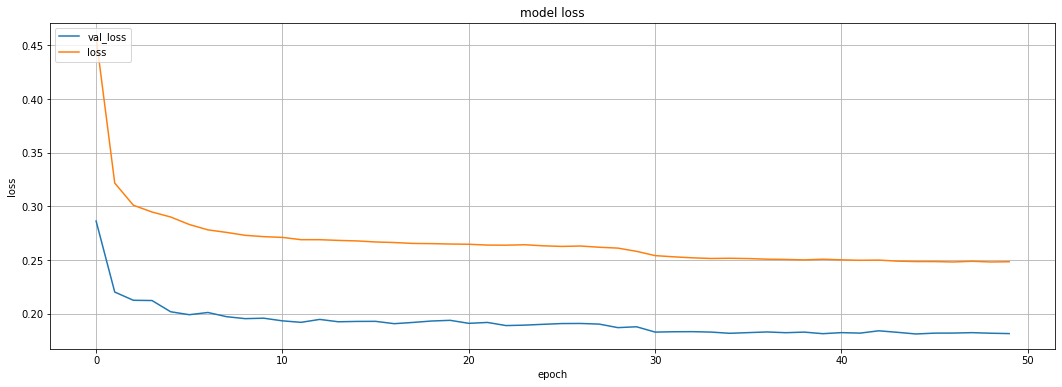

In [ ]:
fig = plt.figure(figsize=(18,6))

# summarize history for loss
plt.plot(history_lstm.history['val_loss'])
plt.plot(history_lstm.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['val_loss','loss'], loc='upper left')
plt.show()#Our results may not be ideal, but they are enough for our purposes.

### LSMT model prediction

Now with our trained model, we can start making some predictions and evaluating those predictions on the test data to see how well our model is doing:

In [ ]:
%%time

# prediction on train
btc_train_predictions = model_lstm.predict(btc_train_observed)
btc_train_predictions_inversed = btc_scaler.inverse_transform(btc_train_predictions)

# prediction on valid
btc_valid_predictions = model_lstm.predict(btc_valid_observed)
btc_valid_predictions_inversed = btc_scaler.inverse_transform(btc_valid_predictions)

# prediction on test
btc_test_predictions = model_lstm.predict(btc_test_observed)
btc_test_predictions_inversed = btc_scaler.inverse_transform(btc_test_predictions)

CPU times: user 9min 26s, sys: 34.2 s, total: 10min 1s
Wall time: 9min 28s


In [ ]:
# We want to add predictions on the dataframe to analysis the model better
# since our observation vector includes 60 elements inside and we start predicting from 61st index that is why we will fill the first 60 index with nan
nan_array = np.empty(d_o)
nan_array[:] = np.NaN

btc_train['scaled_predictions'] = np.concatenate((nan_array, btc_train_predictions.flatten()))
btc_train['inversed_predictions'] = np.concatenate((nan_array, btc_train_predictions_inversed.flatten()))

print('*'*40,'\t btc train: \t','*'*40,'\n')
with pd.option_context('display.max_columns', None): 
  print(btc_train)
  print('\n\n')

btc_valid['scaled_predictions'] = np.concatenate((nan_array, btc_valid_predictions.flatten()))
btc_valid['inversed_predictions'] = np.concatenate((nan_array, btc_valid_predictions_inversed.flatten()))

print('*'*40,'\t btc valid: \t','*'*40,'\n')
with pd.option_context('display.max_columns', None): 
  print(btc_valid)
  print('\n\n')

print('*'*40,'\t btc test: \t','*'*40,'\n')
btc_test['scaled_predictions'] = np.concatenate((nan_array, btc_test_predictions.flatten()))
btc_test['inversed_predictions'] = np.concatenate((nan_array, btc_test_predictions_inversed.flatten()))

with pd.option_context('display.max_columns', None): 
  print(btc_test)
  print('\n\n')

**************************************** 	 btc train: 	 **************************************** 

         Count          VWAP                 Time    Target      Volume  \
1          235  13840.362591  2018-01-01 00:02:00 -0.015037   31.046432   
2          528  13806.068014  2018-01-01 00:03:00 -0.010309   55.061820   
3          435  13783.598101  2018-01-01 00:04:00 -0.008999   38.780529   
4          742  13735.586842  2018-01-01 00:05:00 -0.008079  108.501637   
5          554  13706.952030  2018-01-01 00:06:00 -0.004422   70.805776   
...        ...           ...                  ...       ...         ...   
1636316   1864  44935.449789  2021-02-10 23:56:00 -0.007227   39.538163   
1636317   1826  44913.353225  2021-02-10 23:57:00 -0.008847   48.526747   
1636318   2467  44912.705558  2021-02-10 23:58:00 -0.007998   92.074357   
1636319   2466  44848.417638  2021-02-10 23:59:00 -0.007590   86.665774   
1636320   2956  44862.019363  2021-02-11 00:00:00 -0.010984  111.507314   



## Modelling 2: GRU for ETH

### GRU model train

Although GRUs are very similar to LSTMs, they take fewer parameters and therefore generally run faster. However, LSTMs generally offer better performance on large datasets.

Contrary to LSTM, GRUs only has two gates and these are Reset and Update gate. Basically;

Reset gate - how to merge the new input with the previous memory

Update gate - how much of the previous state will continue to be kept

Let’s see how our architecture looks like:

-- Hyper parameters --

**Layers** : Due to the same reason like LSTM, we used two GRU layers to keep our colab notebook sustainable and eventually it performed enough well.

**num_nodes**: In addition to LSTM, we wanted to keep the number of nodes same proportion but deeper. That is 120 is picked, which is twice of 60.

**Batch Normalization**: We used it to make model faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.

**Activation function**: As we explained in the LSTM section, we think that since the data's scale is zero centred like tanh, tanh fits better into it.

**Dropout**: is simply a layer that tries to prevent the system from memorizing. This time trying 10, instead of 25.

**Loss Function**: Mean Squered Error: Since we are dealing with a regression problem, MSE is the most commonly used loss function.

**Optimizer**: Adam: is a very recent and well-performing optimizer and proper for our task.

**Batch size**: 4096 which is four times lower batch size compared to the one we set for LSTM, in order to make model learn better since chosen epochs is lower.

**Epochs**: Since the model is deeper and slower, 20 is chosen to save time

In [ ]:
model_gru = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape = (btc_train_observed.shape[1], 1)),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.GRU(120, return_sequences=True, activation='tanh'),
              tf.keras.layers.Dropout(0.10),
              tf.keras.layers.BatchNormalization(),
              tf.keras.layers.GRU(120, activation='tanh'),
              tf.keras.layers.Dropout(0.10),
              tf.keras.layers.Dense(1)
])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 60, 1)            4         
 ormalization)                                                   
                                                                 
 gru (GRU)                   (None, 60, 120)           44280     
                                                                 
 dropout_2 (Dropout)         (None, 60, 120)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 60, 120)          480       
 hNormalization)                                                 
                                                                 
 gru_1 (GRU)                 (None, 120)               87120     
                                                                 
 dropout_3 (Dropout)         (None, 120)              

In [ ]:
%%time
model_gru.compile(loss='mean_squared_error', optimizer='adam')
history_gru = model_gru.fit(eth_train_observed, eth_train_next_price, epochs=20, batch_size=4096, validation_data=(eth_valid_observed, eth_valid_next_price))

Epoch 1/20
400/400 [==============================] - 132s 321ms/step - loss: 0.3859 - val_loss: 0.7774
Epoch 2/20
400/400 [==============================] - 127s 317ms/step - loss: 0.3506 - val_loss: 0.2515
Epoch 3/20
400/400 [==============================] - 126s 316ms/step - loss: 0.3341 - val_loss: 0.2389
Epoch 4/20
400/400 [==============================] - 126s 314ms/step - loss: 0.3272 - val_loss: 0.2379
Epoch 5/20
400/400 [==============================] - 125s 313ms/step - loss: 0.3235 - val_loss: 0.2566
Epoch 6/20
400/400 [==============================] - 125s 313ms/step - loss: 0.3129 - val_loss: 0.2226
Epoch 7/20
400/400 [==============================] - 125s 313ms/step - loss: 0.3066 - val_loss: 0.2289
Epoch 8/20
400/400 [==============================] - 125s 313ms/step - loss: 0.3014 - val_loss: 0.2164
Epoch 9/20
400/400 [==============================] - 125s 313ms/step - loss: 0.2941 - val_loss: 0.2166
Epoch 10/20
400/400 [==============================] - 125s 313m

### GRU model performence

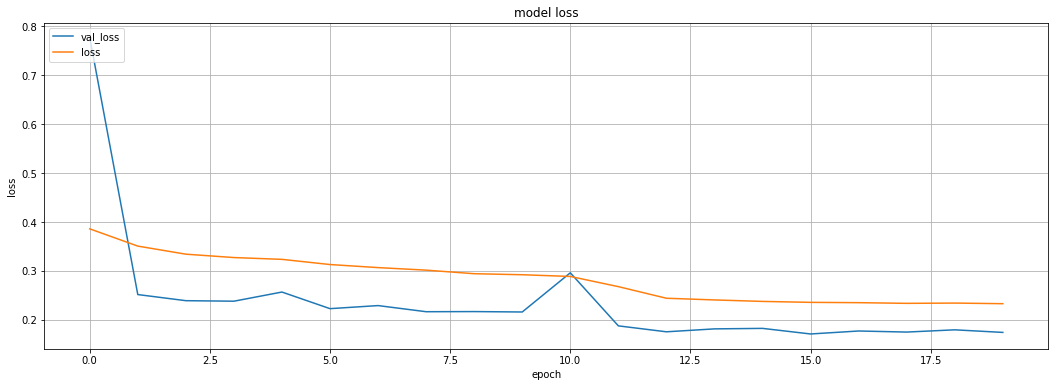

In [ ]:
fig = plt.figure(figsize=(18,6))

# summarize history for loss
plt.plot(history_gru.history['val_loss'])
plt.plot(history_gru.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['val_loss','loss'], loc='upper left')
plt.show()

### GRU model prediction

In [ ]:
%%time

# prediction on train
eth_train_predictions = model_gru.predict(eth_train_observed)
eth_train_predictions_inversed = eth_scaler.inverse_transform(eth_train_predictions)

# prediction on valid
eth_valid_predictions = model_gru.predict(eth_valid_observed)
eth_valid_predictions_inversed = eth_scaler.inverse_transform(eth_valid_predictions)

# prediction on test
eth_test_predictions = model_gru.predict(eth_test_observed)
eth_test_predictions_inversed = eth_scaler.inverse_transform(eth_test_predictions)

CPU times: user 10min 49s, sys: 20.5 s, total: 11min 10s
Wall time: 11min 36s


In [ ]:
# We want to add predictions on the dataframe to analysis the model better
# since our observation vector includes 60 elements inside and we start predicting from 61st index that is why we will fill the first 60 index with nan
nan_array = np.empty(d_o)
nan_array[:] = np.NaN

# train
eth_train['scaled_predictions'] = np.concatenate((nan_array, eth_train_predictions.flatten()))
eth_train['inversed_predictions'] = np.concatenate((nan_array, eth_train_predictions_inversed.flatten()))

print('*'*40,'\t eth train: \t','*'*40,'\n')
with pd.option_context('display.max_columns', None): 
  print(eth_train)
  print('\n\n')

# valid
eth_valid['scaled_predictions'] = np.concatenate((nan_array, eth_valid_predictions.flatten()))
eth_valid['inversed_predictions'] = np.concatenate((nan_array, eth_valid_predictions_inversed.flatten()))

print('*'*40,'\t eth valid: \t','*'*40,'\n')
with pd.option_context('display.max_columns', None): 
  print(eth_valid)
  print('\n\n')

# test
print('*'*40,'\t eth test: \t','*'*40,'\n')
eth_test['scaled_predictions'] = np.concatenate((nan_array, eth_test_predictions.flatten()))
eth_test['inversed_predictions'] = np.concatenate((nan_array, eth_test_predictions_inversed.flatten()))

with pd.option_context('display.max_columns', None): 
  print(eth_test)
  print('\n\n')

**************************************** 	 eth train: 	 **************************************** 

         Count         VWAP                 Time    Target      Volume  \
1          192   738.268967  2018-01-01 00:02:00 -0.004441  232.793141   
2          120   737.994457  2018-01-01 00:03:00 -0.004206  174.138031   
3          156   737.303631  2018-01-01 00:04:00 -0.002205  165.383926   
4          118   736.163026  2018-01-01 00:05:00 -0.001744  193.078039   
5          119   734.816231  2018-01-01 00:06:00 -0.001331  366.585886   
...        ...          ...                  ...       ...         ...   
1636205    952  1744.819326  2021-02-10 23:56:00 -0.007403  361.585855   
1636206   1341  1744.446378  2021-02-10 23:57:00 -0.010088  509.741571   
1636207   1087  1744.657609  2021-02-10 23:58:00 -0.010048  573.788708   
1636208   1128  1743.100228  2021-02-10 23:59:00 -0.008924  662.240731   
1636209   1546  1743.167509  2021-02-11 00:00:00 -0.012347  861.938779   

            

# Evaluation

Pearson product-moment correlation coefficients were chosen for evaluation metrics as default by the organizers.

The Pearson product-moment correlation coefficient is a measure of the linear relationship between two questions/measures/variables, X and Y. The correlation value can range from +1 to -1.

 

A positive correlation (e.g., +0.32) means there is a positive relationship between X and Y. For example, a positive correlation between height and weight means that as height increases, so does weight.

$$
r = \frac{\sum(x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum (x_i - \overline{x})^2\sum (y_i - \overline{y})^2}}
$$


$r$	=	correlation coefficient

$x_i$	=	values of the x-variable in a sample

$\overline{x}$	=	mean of the values of the x-variable

$y_{i}$	=	values of the y-variable in a sample

\$\overline{y}$	=	mean of the values of the y-variable





## Evaluation on model 1: LSTM on btc

### Pearson correlation coefficient

In [ ]:
%%time

# evaluation on train
btc_train_evaluation = np.corrcoef(btc_train['Target'].values[d_o:].flatten(), 
                                   btc_train['inversed_predictions'].values[d_o:].flatten())                      

btc_train_evaluation_scaled = np.corrcoef(btc_train['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_train['scaled_predictions'].values[d_o:].flatten())       



# evaluation on valid
btc_valid_evaluation = np.corrcoef(btc_valid['Target'].values[d_o:].flatten(), 
                                   btc_valid['inversed_predictions'].values[d_o:].flatten())                      

btc_valid_evaluation_scaled = np.corrcoef(btc_valid['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_valid['scaled_predictions'].values[d_o:].flatten())    
     


# evaluation on test
btc_test_evaluation = np.corrcoef(btc_test['Target'].values[d_o:].flatten(), 
                                   btc_test['inversed_predictions'].values[d_o:].flatten())                      

btc_test_evaluation_scaled = np.corrcoef(btc_test['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_test['scaled_predictions'].values[d_o:].flatten())    

CPU times: user 70.3 ms, sys: 8.21 ms, total: 78.5 ms
Wall time: 77.9 ms


### Plot

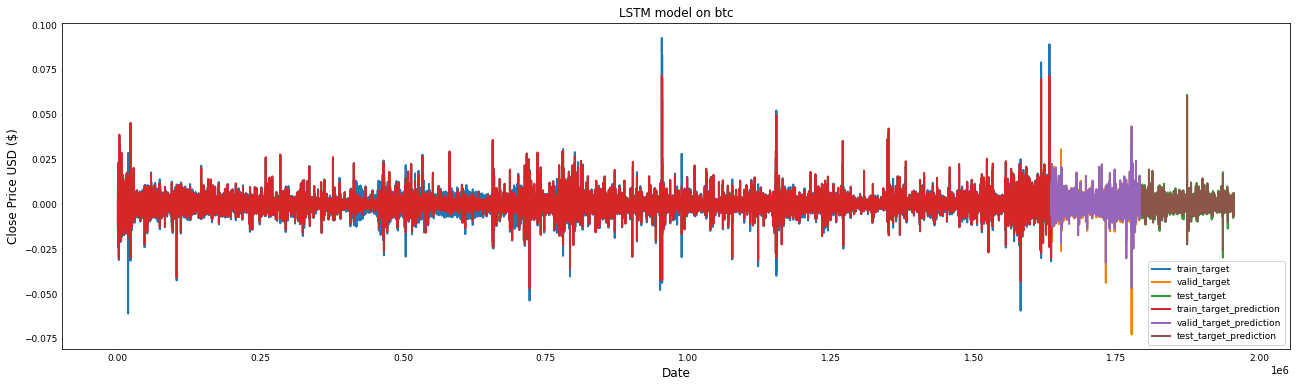




CPU times: user 903 ms, sys: 29.2 ms, total: 932 ms
Wall time: 927 ms


In [ ]:
%%time

# Visualize the data

# Finally predicted values are visualized

plt.figure(figsize=(22,6))
plt.title('LSTM model on btc', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)


plt.plot(btc_train['Target'], linewidth=2.0)
plt.plot(btc_valid['Target'], linewidth=2.0)
plt.plot(btc_test['Target'], linewidth=2.0)

plt.plot(btc_train['inversed_predictions'], linewidth=2.0)
plt.plot(btc_valid['inversed_predictions'], linewidth=2.0)
plt.plot(btc_test['inversed_predictions'], linewidth=2.0)


plt.legend(['train_target', 'valid_target', 'test_target', 'train_target_prediction', 'valid_target_prediction', 'test_target_prediction'], loc='lower right', fontsize=9)
plt.show()

print('\n\n')


### Scatter plot

CPU times: user 509 ms, sys: 5.67 ms, total: 514 ms
Wall time: 508 ms


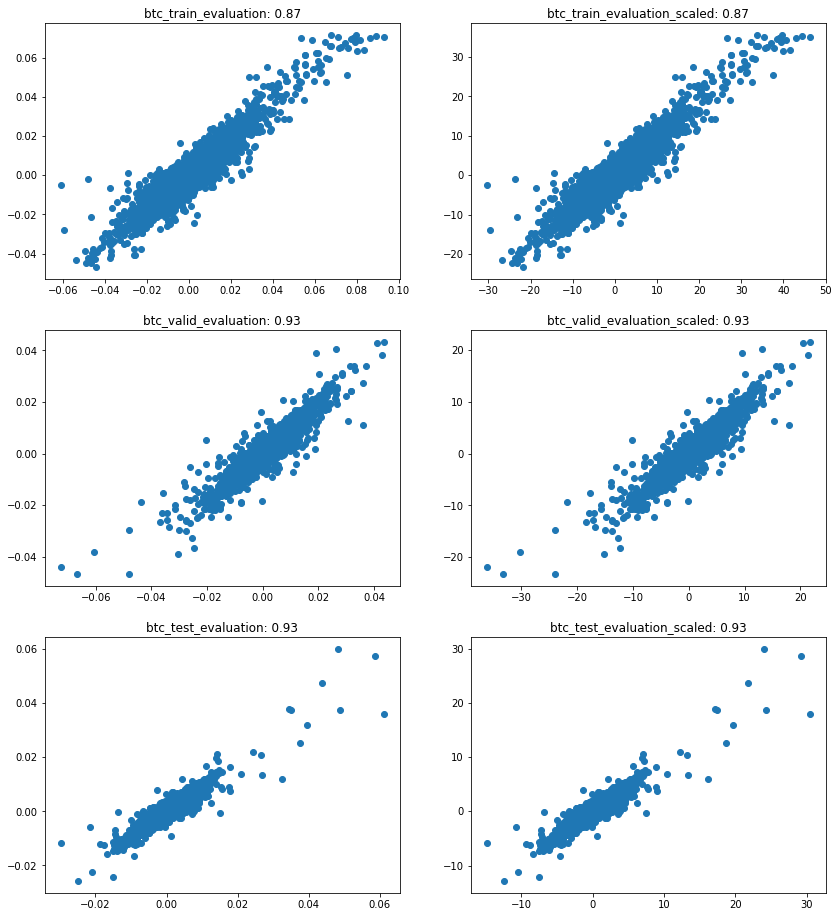

In [ ]:
%%time
fig = plt.figure(figsize=(14,16))

# train
plt.subplot(3,2,1)
plt.scatter(btc_train['Target'].values[d_o:].flatten(), 
                                   btc_train['inversed_predictions'].values[d_o:].flatten())
plt.title(f'btc_train_evaluation: {btc_train_evaluation[0,1]:.2f}')

plt.subplot(3,2,2)
plt.scatter(btc_train['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_train['scaled_predictions'].values[d_o:].flatten())
plt.title(f'btc_train_evaluation_scaled: {btc_train_evaluation_scaled[0,1]:.2f}')


# valid
plt.subplot(3,2,3)
plt.scatter(btc_valid['Target'].values[d_o:].flatten(), 
                                   btc_valid['inversed_predictions'].values[d_o:].flatten())
plt.title(f'btc_valid_evaluation: {btc_valid_evaluation[0,1]:.2f}')


plt.subplot(3,2,4)
plt.scatter(btc_valid['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_valid['scaled_predictions'].values[d_o:].flatten())
plt.title(f'btc_valid_evaluation_scaled: {btc_valid_evaluation_scaled[0,1]:.2f}')


# test
plt.subplot(3,2,5)
plt.scatter(btc_test['Target'].values[d_o:].flatten(), 
                                   btc_test['inversed_predictions'].values[d_o:].flatten())
plt.title(f'btc_test_evaluation: {btc_test_evaluation[0,1]:.2f}')


plt.subplot(3,2,6)
plt.scatter(btc_test['Scaled_Target'].values[d_o:].flatten(), 
                                          btc_test['scaled_predictions'].values[d_o:].flatten())
plt.title(f'btc_test_evaluation_scaled: {btc_test_evaluation_scaled[0,1]:.2f}')

## Evaluation model 2: GRU on eth



### Pearson correlation coefficient

In [ ]:
%%time

# evaluation on train
eth_train_evaluation = np.corrcoef(eth_train['Target'].values[d_o:].flatten(), 
                                   eth_train['inversed_predictions'].values[d_o:].flatten())                      

eth_train_evaluation_scaled = np.corrcoef(eth_train['Scaled_Target'].values[d_o:].flatten(), 
                                          eth_train['scaled_predictions'].values[d_o:].flatten())       



# evaluation on valid
eth_valid_evaluation = np.corrcoef(eth_valid['Target'].values[d_o:].flatten(), 
                                   eth_valid['inversed_predictions'].values[d_o:].flatten())                      

eth_valid_evaluation_scaled = np.corrcoef(eth_valid['Scaled_Target'].values[d_o:].flatten(), 
                                          eth_valid['scaled_predictions'].values[d_o:].flatten())    
     


# evaluation on test
eth_test_evaluation = np.corrcoef(eth_test['Target'].values[d_o:].flatten(), 
                                  eth_test['inversed_predictions'].values[d_o:].flatten())                      

eth_test_evaluation_scaled = np.corrcoef(eth_test['Scaled_Target'].values[d_o:].flatten(), 
                                         eth_test['scaled_predictions'].values[d_o:].flatten())  

CPU times: user 69.1 ms, sys: 5.07 ms, total: 74.2 ms
Wall time: 74.5 ms


### Plot

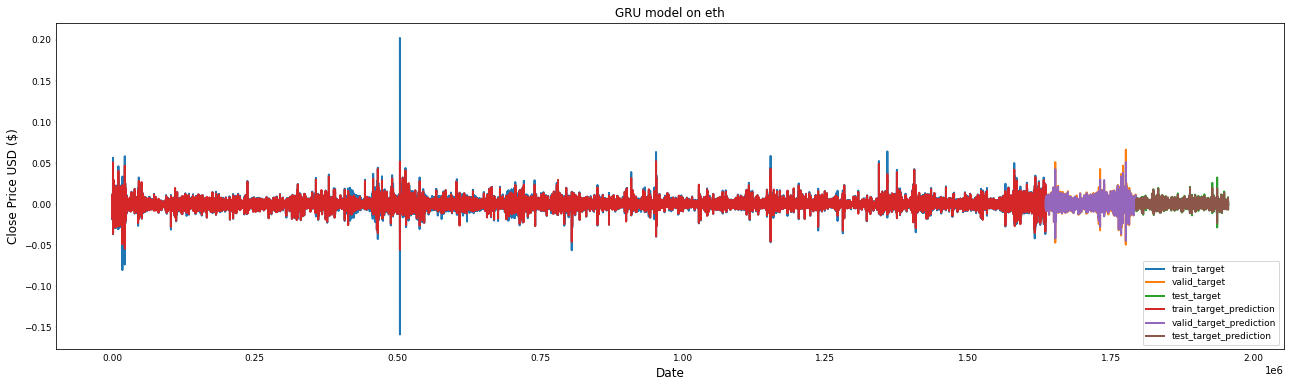




CPU times: user 880 ms, sys: 17 ms, total: 897 ms
Wall time: 893 ms


In [ ]:
%%time

# Visualize the data

# Finally predicted values are visualized

plt.figure(figsize=(22,6))
plt.title('GRU model on eth', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)

plt.plot(eth_train['Target'], linewidth=2.0)
plt.plot(eth_valid['Target'], linewidth=2.0)
plt.plot(eth_test['Target'], linewidth=2.0)

plt.plot(eth_train['inversed_predictions'], linewidth=2.0)
plt.plot(eth_valid['inversed_predictions'], linewidth=2.0)
plt.plot(eth_test['inversed_predictions'], linewidth=2.0)


plt.legend(['train_target', 'valid_target', 'test_target', 'train_target_prediction', 'valid_target_prediction', 'test_target_prediction'], loc='lower right', fontsize=9)
plt.show()

print('\n\n')

### Scatter Plot

CPU times: user 525 ms, sys: 4.74 ms, total: 529 ms
Wall time: 527 ms


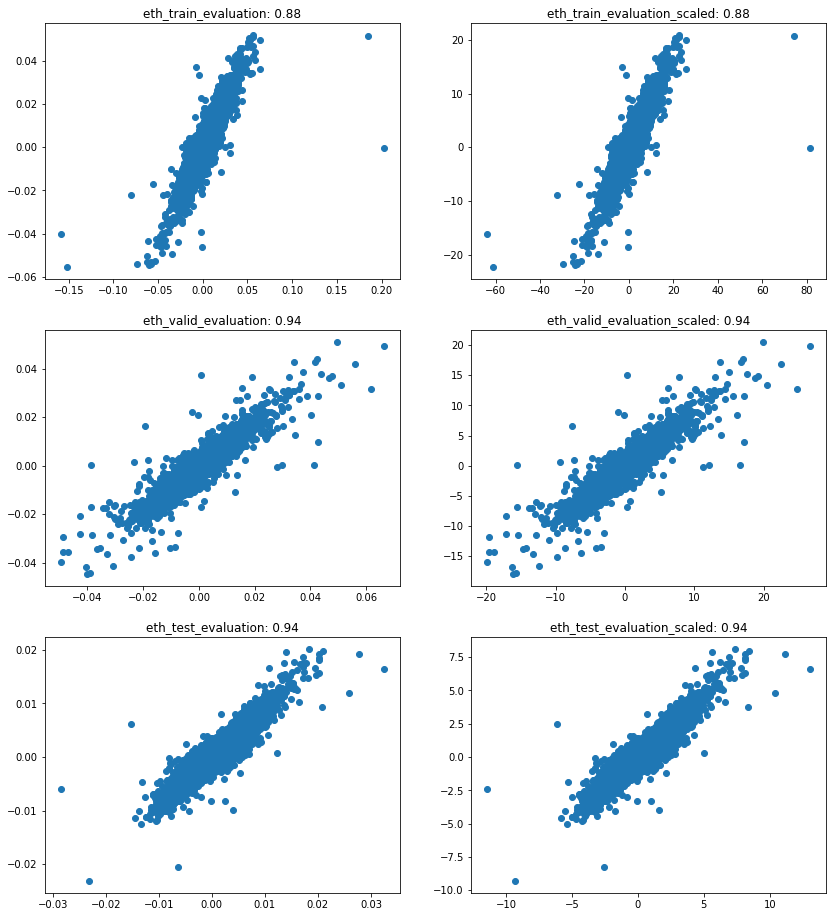

In [ ]:
%%time
fig = plt.figure(figsize=(14,16))

# train
plt.subplot(3,2,1)
plt.scatter(eth_train['Target'].values[d_o:].flatten(), 
            eth_train['inversed_predictions'].values[d_o:].flatten())

plt.title(f'eth_train_evaluation: {eth_train_evaluation[0,1]:.2f}')

plt.subplot(3,2,2)
plt.scatter(eth_train['Scaled_Target'].values[d_o:].flatten(), 
            eth_train['scaled_predictions'].values[d_o:].flatten())

plt.title(f'eth_train_evaluation_scaled: {eth_train_evaluation_scaled[0,1]:.2f}')


# valid
plt.subplot(3,2,3)
plt.scatter(eth_valid['Target'].values[d_o:].flatten(), 
            eth_valid['inversed_predictions'].values[d_o:].flatten())

plt.title(f'eth_valid_evaluation: {eth_valid_evaluation[0,1]:.2f}')


plt.subplot(3,2,4)
plt.scatter(eth_valid['Scaled_Target'].values[d_o:].flatten(), 
            eth_valid['scaled_predictions'].values[d_o:].flatten())

plt.title(f'eth_valid_evaluation_scaled: {eth_valid_evaluation_scaled[0,1]:.2f}')


# test
plt.subplot(3,2,5)
plt.scatter(eth_test['Target'].values[d_o:].flatten(), 
            eth_test['inversed_predictions'].values[d_o:].flatten())

plt.title(f'eth_test_evaluation: {eth_test_evaluation[0,1]:.2f}')


plt.subplot(3,2,6)
plt.scatter(eth_test['Scaled_Target'].values[d_o:].flatten(), 
            eth_test['scaled_predictions'].values[d_o:].flatten())

plt.title(f'eth_test_evaluation_scaled: {eth_test_evaluation_scaled[0,1]:.2f}')

# Comments

## Regarding to model 1: LSTM

Even though we did not train any deep and complex LSTM model, still, we got quite good performance on test set. We think the main reason that led us to good performance is not only related to the model, also how we split and scaled the data into train, valid and test. Additionally, there might be some information leakage that helps the model learn a good way but we couldn't find any leakage tough we over checked all steps many times. So far, with a simple LSTM model and without scaling the data, we scored the lowest score 0.79 on the test set. The best score we got, with scaled data and a more complex model, is 0.93. We think that if we were able to build more complex data including regularization, batch normalization and more, we might have gotten even higher scores.


## Regarding to model 2: GRU

Contrary to our expectation, GRU performed slightly better performance on Pearson product-moment correlation coefficients compared to the LSTM model. We think that having a deeper model compared to LSTM, helped the GRU model comprehend the data much better.

## Regarding to hyper-parameters

The type of activation function used affects accuracy. Although sigmoid and tanh activation functions are quite successful, these two might cause vanishing gradient problem in practice. Relu is more successful in this regard. However, we got the highest accuracy from tanh activation function. Because tanh could work in high harmony with the data, since our data is zero-centered just like tanh function.

We worked with several different batch sizes. Considering that our data is very large and we were working with at least 10 epochs, we needed to find a rational value in the performance/running time balance. Since a smaller number of batch size leds more iteration in each epoch, it gives higher accuracy than the larger ones. So, we got better performance with 4096 batch size than the ones we tried up to 32768.

When we increase the number of nodes, it is possible to say that we generally achieve higher accuracy. Since we encountered various values in different notebooks, we intuitively used values of 30, 60, 120 and observed that larger node number increases accuracy.

## Regarding to technical analysis

To analyse the data better and have a solid model to predict its future, we tried implementing several technical analysis methods such as ROC Indicator, RSI and so on. In fact, we did not clearly understand what does those indicator methods do since our background is not related to Economics, which is why we did not achieve implementing them as wanted. Also, if we had trained fully connected dense layers, we could have used several inputs including the ones analysed with indicators, but instead, we decided to implement some RNN models in order to learn them closer by using them.

## Final comments


This notebook describes our own approaches to the G-Research Crypto Competition proposed by Kaggle, whichserved as a sub-assignment for the Deep Learning and Text Analysis in Finance course at the University of Passau. 

For this purpose, we came up with two modelling approaches like LSTM on btc and GRU on eth, yet, both obtained similar and interesting results.

However, we are afraid of information leakage in data since we always got a high score from evaluation for all the sets even though we double-checked all the processes. 

Also, we particularly found out that using deeper and more complex models might give interesting results, hence, there is certainly space for research.

Nevertheless, it was an enlightening experience and a nice discovery of the RNN world where lots of exciting new discoveries happening in recent years.